<a href="https://colab.research.google.com/github/vchen007/Spoon-Knife/blob/main/DFS_optimization_pyomo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Looking at optimizing daily fantasy sports using python and the pyomo library
- Daily Fantasy Sports games are considered a skill-based game where participants can choose players in a sports league and earn points based on cerntain statistics. There is an entry fee for each line up submitted and the lineup with the most points wins the prize pool.
- The National Football League is the most popular of the fantasy sports.
- There are many different contests users can enter and select players such as single games, entire weekly games, and certain periods such as morning or afternoon slate of games.
- The National Football League consists of a 18 week schedule starting with Thursday Night Football and ending on Monday Night Football.
- FanDuel and DraftKings are the largest and most used daily fantasy sports sites.
- The positions needed are 1 quarterback, 2 running backs, 3 wide receivers, 1 tight end, 1 team defense and 1 flex position which can be either a running back, wide receiver or tight end.
- The data for this project was collected from rotowire.com

In [59]:
#Copy-and-paste the code below to use as "set-up" when your optimization model uses Pyomo and Coin-OR solvers.
#for reference, see https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers

%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

from pyomo.environ import *

In [60]:
import pandas as pd

In [61]:
# Importing data
df = pd.read_csv('rotowire-NFL-players.csv')

In [62]:
df.head()

,PLAYER,POS,TEAM,OPP,ML,O/U,SPRD,TM/P,SAL,FPTS,VAL,RST%
0,Kyren Williams,RB,LAR,WAS,-300,50.5,-6.5,28.5,7500,18.65,2.5,24.92
1,Ezekiel Elliott,RB,NE,KC,332,37.5,8.5,14.5,5800,15.19,2.6,24.17
2,Christian McCaffrey,RB,SF,ARI,-780,48.5,-12.5,30.5,9300,23.02,2.5,23.33
3,Antonio Gibson,RB,WAS,LAR,241,50.5,6.5,22.0,5200,14.64,2.8,20.82
4,Matthew Stafford,QB,LAR,WAS,-300,50.5,-6.5,28.5,6000,17.19,2.9,15.14


### Going through each column of the dataset

1. Player - NFL player's name
2. POS - The skilled position which include
{QB: quaterback, RB: running back, WR: wide receiver, TE: tight end, D: team defense}
3. TEAM - team the position player plays for
4. OPP - the opposing team for that week
5. ML - the moneyline odds of the team winning. Minus odds are favorite while plus odds are underdog
6. O/U - the betting total of the game that week
7. SPRD - the point spread of that game.  Minus points are favorite while plus points are underdog
8. TM/P - points per game for that team
9. SAL - the Daily Fantasy Sports salary for choosing that player
10. FPTS - the fantasy points predicted
11. VAL - FPTS divided by the SAL times 1000
12. RST% - the percent of daily fantasy teams that the player is rostered on


In [63]:
df['POS'].value_counts()

WR    144
RB     91
TE     83
QB     54
D      20
Name: POS, dtype: int64

In [64]:
# keeping the position names
pos_names = df['POS']

In [65]:
df = pd.get_dummies(df, columns=['POS'])

### For selecting each positioin, I have created dummy variables for each position: QB, RB, WR, TE and team defense so I can use the dummies as contraint values.

In [66]:
df = pd.concat([df, pos_names], axis=1)

In [67]:
df.head()

,PLAYER,TEAM,OPP,ML,O/U,SPRD,TM/P,SAL,FPTS,VAL,RST%,POS_D,POS_QB,POS_RB,POS_TE,POS_WR,POS
0,Kyren Williams,LAR,WAS,-300,50.5,-6.5,28.5,7500,18.65,2.5,24.92,0,0,1,0,0,RB
1,Ezekiel Elliott,NE,KC,332,37.5,8.5,14.5,5800,15.19,2.6,24.17,0,0,1,0,0,RB
2,Christian McCaffrey,SF,ARI,-780,48.5,-12.5,30.5,9300,23.02,2.5,23.33,0,0,1,0,0,RB
3,Antonio Gibson,WAS,LAR,241,50.5,6.5,22.0,5200,14.64,2.8,20.82,0,0,1,0,0,RB
4,Matthew Stafford,LAR,WAS,-300,50.5,-6.5,28.5,6000,17.19,2.9,15.14,0,1,0,0,0,QB


### I have created lists for salary, projected fantasy points, position and roster percentage.

In [68]:
#salary list
salary = df['SAL'].tolist()

In [69]:
#Projected Fantasy points list
projected_points = df['FPTS'].tolist()

In [70]:
# List for each position
QB_list = df['POS_QB'].tolist()
RB_list = df['POS_RB'].tolist()
WR_list = df['POS_WR'].tolist()
TE_list = df['POS_TE'].tolist()
DEF_list = df['POS_D'].tolist()

In [71]:
# Roster percent list
roster_percent = df['RST%'].tolist()

### Looking at the roster percentage, we can see that the majority of players are at 0 percent. We can create a constraint where we can have the average roster percentage be over or under a certain value using roster_low as the average of the roster percent as a whole percent.

array([[<Axes: title={'center': 'RST%'}>]], dtype=object)

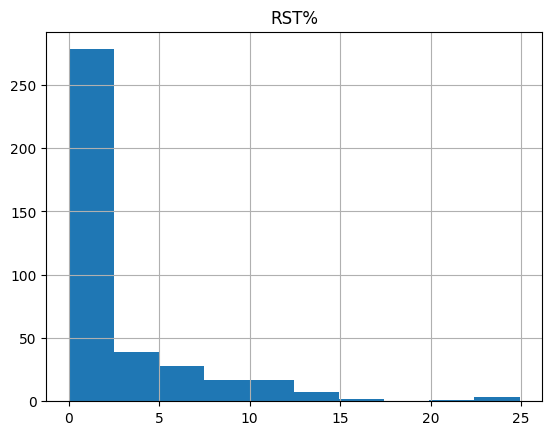

In [72]:
# Histogram of the roster percent. High roster percent means players are in many lineups
df.hist(column='RST%')

### The budget can be adjusted based on the Daily Fantasy Sports site as well as the number of positions.

In [78]:
# Total Budget for the entire lineup
budget = 50000

# Number of positions
num_QB = 1
num_RB = 2
max_RB = 3
num_WR = 3
max_WR = 4
num_TE = 1
max_TE = 2
num_Flex = 1
num_DEF = 1

#Average of the roster percent as an whole percent
roster_low = 6

#Position Requirements
position_list = ['QB', 'RB', 'RB', 'WR', 'WR', 'WR', 'TE', 'FLEX', 'DST']
num_positions = len(position_list) #QB, RB, RB, WR, WR, WR, TE, FLEX, DEF

# Length of entire data set
n = len(salary)

#define the concrete model
model = ConcreteModel()

#DVs
model.x = Var(range(n), domain = Binary)

#objective
model.Objective = Objective(expr = sum(model.x[i]*projected_points[i] for i in range(n)), sense = maximize)

#budget constraint
model.BudgetConstraint = Constraint(expr = sum(model.x[i]*salary[i] for i in range(n)) <= budget)

# Position Constraints. We need
model.num_positionConstraint = Constraint(expr = sum(model.x[i] for i in range(n)) == num_positions)
model.QBConstraint = Constraint(expr = sum(model.x[i]*QB_list[i] for i in range(n)) == num_QB)
model.RBConstraint = Constraint(expr = sum(model.x[i]*RB_list[i] for i in range(n)) == num_RB)
model.RBConstraint = Constraint(expr = sum(model.x[i]*RB_list[i] for i in range(n)) <= max_RB)
model.WRConstraint = Constraint(expr = sum(model.x[i]*WR_list[i] for i in range(n)) == num_WR)
model.WRConstraint = Constraint(expr = sum(model.x[i]*WR_list[i] for i in range(n)) <= max_WR)
model.TEConstraint = Constraint(expr = sum(model.x[i]*TE_list[i] for i in range(n)) == num_TE)
model.TEConstraint = Constraint(expr = sum(model.x[i]*TE_list[i] for i in range(n)) <= max_TE)
model.DEFConstraint = Constraint(expr = sum(model.x[i]*DEF_list[i] for i in range(n)) == num_DEF)

#Constraint for average roster percentage of the players chosen. We can adjust for popular or unpopular players
model.RSTConstraint = Constraint(expr = sum(model.x[i]*roster_percent[i] for i in range(n)) / num_positions >= roster_low)

# Printing the model and seeing what rows are selected
model.pprint()

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1 Var Declarations
    x : Size=392, Index={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 2

In [80]:
#solve the model
opt = SolverFactory('cbc')
opt.options['seconds'] = 5 #specifies the time limit (in seconds)
#####QUESTION C SOLUTION########### change the ratioGap below to zero:
opt.options['ratioGap'] = 0 #specifies the optimality gap tolerance (.01 means alg can stop if guarenteed within <1% of optimal obj)
results = opt.solve(model, tee=True)

Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Jun  7 2023 

command line - /content/bin/cbc -seconds 5 -ratioGap 0 -printingOptions all -import /tmp/tmphsoq417g.pyomo.lp -stat=1 -solve -solu /tmp/tmphsoq417g.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 5
ratioGap was changed from 0 to 0
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve 8 (0) rows, 392 (0) columns and 1335 (-74) elements
Statistics for presolved model
Original problem has 392 integers (392 of which binary)
==== 135 zero objective 235 different
==== absolute objective values 235 different
==== for integers 135 zero objective 235 different
==== for integers absolute objective values 235 different
===== end objective counts


Problem has 8 rows, 392 columns (257 with objective) and 1335 elements
Column breakdown:
0 of type 0.0->inf, 0 of 

### This is the optimized lineup with the highest projected fantasy points based on the budget of $50,000 and the roster percentage greater than or equal to 4 percent.

In [81]:
#print out solution
pos = []
player = []
points = []
print("Choose theses players: ")
for i in range(n):
    if model.x[i]() == 1:
        print(df.loc[i]['POS'])
        pos.append(df.loc[i]['POS'])
        print(df.loc[i]['PLAYER'])
        player.append(df.loc[i]['PLAYER'])
        print(df.loc[i]['FPTS'])
        points.append(df.loc[i]['FPTS'])

print("Total Projected Points:", model.Objective())
print("Total Budget:", model.BudgetConstraint())
print("Average Roster Percet", model.RSTConstraint())

Choose theses players: 
RB
Ezekiel Elliott
15.19
RB
Christian McCaffrey
23.02
RB
Antonio Gibson
14.64
WR
Garrett Wilson
14.06
WR
Terry McLaurin
13.36
D
Carolina Panthers
6.89
TE
Chigoziem Okonkwo
6.94
QB
Josh Allen
23.46
WR
Rashid Shaheed
10.0
Total Projected Points: 127.56
Total Budget: 49900.0
Average Roster Percet 15.704444444444444


### I have created an excel output to load the lineup into a Daily Fantasy Sports site.

In [85]:
excel_output = pd.DataFrame({'Position': pos, 'Player': player, 'Projected Points': points})

In [88]:
excel_output

,Position,Player,Projected Points
0,RB,Ezekiel Elliott,15.19
1,RB,Christian McCaffrey,23.02
2,RB,Antonio Gibson,14.64
3,WR,Garrett Wilson,14.06
4,WR,Terry McLaurin,13.36
5,D,Carolina Panthers,6.89
6,TE,Chigoziem Okonkwo,6.94
7,QB,Josh Allen,23.46
8,WR,Rashid Shaheed,10.00


In [89]:
excel_output.to_excel('output.xlsx', sheet_name='Lineup 1', index=False)

In [91]:
!jupyter nbconvert --to markdown DFS_optimization_pyomo.ipynb

[NbConvertApp] Converting notebook DFS_optimization_pyomo.ipynb to markdown
[NbConvertApp] Support files will be in DFS_optimization_pyomo_files/
[NbConvertApp] Making directory DFS_optimization_pyomo_files
[NbConvertApp] Writing 162214 bytes to DFS_optimization_pyomo.md
